In [1]:
import os,sys
import numpy as np
from collections import namedtuple
import tqdm
import glob
import math
import random
import inspect
import os.path as osp
from pathlib import Path
import itertools
from itertools import chain
import numpy as np
import pandas as pd
import multiprocessing
import h5py
import matplotlib.pyplot as plt
import numpy as np
import sys, os
from importlib import reload

import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch_geometric.data import Data, DataLoader, DataListLoader
from torch_geometric.nn import EdgeConv, global_mean_pool, DataParallel
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.data import Data,Dataset
from torch_scatter import scatter_mean, scatter
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch_geometric.nn import MetaLayer, EdgeConv, global_mean_pool, DynamicEdgeConv
import h5py

In [116]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('../')))

import models_torch.models as models
reload(models)
import models_torch.losses as losses
reload(losses)
import utils_torch.scaler
reload(utils_torch.scaler)
import utils_torch.preprocessing as prepr
import utils_torch.plot_util as plot
reload(plot)
import utils_torch.train_util as train
reload(train)
import graph_data.graph_data as graph_data
reload(graph_data)
import utils_torch.model_summary as summary
reload(summary)

sys.path.append(os.path.abspath(os.path.join('../../')))
import vande.util.util_plotting as vande_plot
reload(vande_plot)

sys.path.append(os.path.abspath(os.path.join('../../')))
sys.path.append(os.path.abspath(os.path.join('../../DarkFlow/darkflow/')))
import DarkFlow.darkflow.networks.flows as flows


In [3]:
data_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/output_models/pytroch/'
dataset = graph_data.GraphDataset(root=data_dir,n_jets=1e3)
save_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/output_models/pytroch/input_feats/'
   
use_generator = False
if use_generator:
    validation_split = 0.2
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    if dataset_size > 2:
        split = int(np.floor(validation_split * dataset_size))
    else: 
        split = 1
    print(dataset_size,split)
    random_seed= 1001

    train_subset, val_subset = torch.utils.data.random_split(dataset, [dataset_size - split, split],
                                                             generator=torch.Generator().manual_seed(random_seed))
    print("train subset dim:", len(train_subset))
    print("validation subset dim", len(val_subset))
    dataloaders = {
        'train':  DataLoader(train_subset, batch_size=128, shuffle=True),
        'val':   DataLoader(val_subset, batch_size=128, shuffle=True)
    }
    print("train_dataloader dim:", len(dataloaders['train']))
    print("val dataloader dim:", len(dataloaders['val']))
else : 
    in_memory_datas = dataset.return_inmemory_data() 

In [ ]:
pf_cands,jet_prop = dataset.pf_cands,dataset.jet_prop
pf_cands_t = torch.cat([torch.tensor(pf_cands[i], dtype=torch.float) for i in range(len(pf_cands))])
#Plot consistuents and jet features prepared for the graph! (but before any normalization)
pf_feats = 'px,py,pz,E,pt,eta,phi'.split(',')
jet_feats = 'N_constituents,M,Pt,Eta,Phi'.split(',')


save_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/output_models/pytroch/input_feats/'
vande_plot.plot_features(pf_cands_t.numpy(), pf_feats ,'Normalized' , 'QCD', plotname='{}plot_pf_feats_{}'.format(save_dir,'QCD_side'), legend=['QCD'], ylogscale=True)
vande_plot.plot_features(jet_prop[:,0:-1], jet_feats ,'Normalized' , 'QCD', plotname='{}plot_jet_feats_{}'.format(save_dir,'QCD_side'), legend=['QCD'], ylogscale=True)


In [4]:
#scaler = standardize(train_subset) # I dont think that this works for the dataset implementation as it is done now, implement scaler as part of dataset ? 
scaler = prepr.standardize(in_memory_datas,minmax_idx=[3,4],log_idx=[3,4]) 

dataloaders = {
    'train':  DataLoader(in_memory_datas, batch_size=128, shuffle=True)
    }
print("train_dataloader dim:", len(dataloaders['train']))

#dataset.get(0).u

train_dataloader dim: 8


In [ ]:
pf_cands_norm = torch.cat([torch.tensor(in_memory_datas[i].x, dtype=torch.float) for i in range(len(in_memory_datas))])
#Plot consistuents and jet features prepared for the graph! (after normalization)
pf_feats = 'px,py,pz,E,pt,eta,phi'.split(',')
save_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/output_models/pytroch/input_feats_normalized/'
vande_plot.plot_features(pf_cands_norm.numpy(), pf_feats ,'Normalized' , 'QCD', plotname='{}plot_pf_feats_{}'.format(save_dir,'QCD_side'), legend=['QCD'], ylogscale=True)


In [5]:
torch.manual_seed(0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
multi_gpu = False #torch.cuda.device_count()>1

In [101]:
# model
input_dim = 7
output_dim = 4#7#4#4,7
big_dim = 32
hidden_dim = 2
#model = models.EdgeNet(input_dim=input_dim,output_dim=output_dim, big_dim=big_dim, hidden_dim=hidden_dim)
#model = models.EdgeNetVAE(input_dim=input_dim,output_dim=output_dim, big_dim=big_dim, hidden_dim=hidden_dim)
model = models.PlanarEdgeNetVAE(input_dim=input_dim,output_dim=output_dim, big_dim=big_dim, hidden_dim=hidden_dim)

optimizer = torch.optim.Adam(model.parameters(), lr = 10e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, threshold=1e-6)

model.to(device)
print(model)
summary.gnn_model_summary(model)

PlanarEdgeNetVAE(
  (mu_layer): Linear(in_features=32, out_features=2, bias=True)
  (var_layer): Linear(in_features=32, out_features=2, bias=True)
  (batchnorm): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder): EdgeConv(nn=Sequential(
    (0): Linear(in_features=14, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
  ))
  (decoder): EdgeConv(nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
  ))
  (amor_u): Linear(in_features=32, out_features=12, bias=True)
  (amor_w): Linear(in_features=32, out_features=12, bias=True)
  (amor_b): Linear(in_features=32, out_features=6, bias=True)
  (flow_0): Planar(
    (h): Tanh()
    (softplus): Softplus(beta=1, threshold=20)
  )
  (flow_1): Planar(
    (h): Tanh()
  

In [104]:
#loss
#loss_ftn_obj = losses.LossFunction('mse_coordinates', device=device)
#loss_ftn_obj = losses.LossFunction('mse', device=device)
#loss_ftn_obj = losses.LossFunction('vae_loss_mse',beta=0.00001,device=device)
loss_ftn_obj = losses.LossFunction('vae_loss_mse_coord',beta=0.00001,device=device)

# Training loop
n_epochs = 80
stale_epochs = 0
loss = 999999
#train_losses = []
for epoch in range(0, n_epochs):
    #loss = train(model, optimizer, loader, len(datas), 128, loss_ftn_obj)
    loss_tot,loss_reco,loss_kl = train.train(model, optimizer, dataloaders['train'], len(dataloaders['train'].dataset), dataloaders['train'].batch_size, loss_ftn_obj)
    #train_losses.append(loss)
    print('Epoch: {:02d}, Training Loss Tot, Reco, KL :  {:.4f},{:.4f}, {:.4f}'.format(epoch, loss_tot,loss_reco,loss_kl))















  0%|          | 0/7.8125 [00:00<?, ?it/s]













train loss tot = 0.9598760,train loss reco = 0.9591177,train loss kl = 76.7933121:   0%|          | 0/7.8125 [00:00<?, ?it/s]













train loss tot = 0.9598760,train loss reco = 0.9591177,train loss kl = 76.7933121:   0%|          | 0/7.8125 [00:00<?, ?it/s]













train loss tot = 0.9598760,train loss reco = 0.9591177,train loss kl = 76.7933121:  13%|█▎        | 1/7.8125 [00:00<00:00,  7.08it/s]













train loss tot = 0.7227778,train loss reco = 0.7209011,train loss kl = 188.3990326:  13%|█▎        | 1/7.8125 [00:00<00:00,  7.08it/s]













train loss tot = 0.7227778,train loss reco = 0.7209011,train loss kl = 188.3990326:  13%|█▎        | 1/7.8125 [00:00<00:00,  7.08it/s]













train loss tot = 0.7227778,train loss reco = 0.7209011,train loss kl = 188.3990326:  26%|██▌       | 2/7.8125 [00:00<00:00,  7.70it/s]













train loss tot = 0.8720653,train loss reco = 0.8700520,train 

Epoch: 00, Training Loss Tot, Reco, KL :  0.7649,0.7632, 171.1530
















train loss tot = 0.6940501,train loss reco = 0.6919725,train loss kl = 208.4499664:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.94it/s]













train loss tot = 0.6940501,train loss reco = 0.6919725,train loss kl = 208.4499664:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.94it/s]













train loss tot = 0.6940501,train loss reco = 0.6919725,train loss kl = 208.4499664:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.82it/s]













train loss tot = 0.6286235,train loss reco = 0.6265020,train loss kl = 212.7740479:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.82it/s]













train loss tot = 0.6286235,train loss reco = 0.6265020,train loss kl = 212.7740479:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.82it/s]













train loss tot = 0.6286235,train loss reco = 0.6265020,train loss kl = 212.7740479:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.79it/s]













train loss tot = 0.6211777,train loss reco = 0.6187739,train loss kl = 241.0022430:  38%|███▊     

Epoch: 01, Training Loss Tot, Reco, KL :  0.5954,0.5924, 299.6132
















train loss tot = 0.5075234,train loss reco = 0.4991918,train loss kl = 833.6625977:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.93it/s]













train loss tot = 0.5075234,train loss reco = 0.4991918,train loss kl = 833.6625977:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.93it/s]













train loss tot = 0.5075234,train loss reco = 0.4991918,train loss kl = 833.6625977:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.90it/s]













train loss tot = 0.5580287,train loss reco = 0.5479765,train loss kl = 1005.7702026:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.90it/s]













train loss tot = 0.5580287,train loss reco = 0.5479765,train loss kl = 1005.7702026:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.90it/s]













train loss tot = 0.5580287,train loss reco = 0.5479765,train loss kl = 1005.7702026:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.89it/s]













train loss tot = 0.4769751,train loss reco = 0.4660714,train loss kl = 1090.8422852:  38%|███▊ 

Epoch: 02, Training Loss Tot, Reco, KL :  0.4996,0.4887, 1088.6473
















train loss tot = 0.3859514,train loss reco = 0.3705898,train loss kl = 1536.5318604:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.75it/s]













train loss tot = 0.3859514,train loss reco = 0.3705898,train loss kl = 1536.5318604:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.75it/s]













train loss tot = 0.3859514,train loss reco = 0.3705898,train loss kl = 1536.5318604:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.72it/s]













train loss tot = 0.4267148,train loss reco = 0.4114880,train loss kl = 1523.0930176:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.72it/s]













train loss tot = 0.4267148,train loss reco = 0.4114880,train loss kl = 1523.0930176:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.72it/s]













train loss tot = 0.4267148,train loss reco = 0.4114880,train loss kl = 1523.0930176:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.72it/s]













train loss tot = 0.4479432,train loss reco = 0.4346311,train loss kl = 1331.6350098:  38%|██

Epoch: 03, Training Loss Tot, Reco, KL :  0.4426,0.4291, 1349.8503
















train loss tot = 0.3404526,train loss reco = 0.3280161,train loss kl = 1243.9820557:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.85it/s]













train loss tot = 0.3404526,train loss reco = 0.3280161,train loss kl = 1243.9820557:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.85it/s]













train loss tot = 0.3404526,train loss reco = 0.3280161,train loss kl = 1243.9820557:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.81it/s]













train loss tot = 0.4020991,train loss reco = 0.3915220,train loss kl = 1058.1057129:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.81it/s]













train loss tot = 0.4020991,train loss reco = 0.3915220,train loss kl = 1058.1057129:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.81it/s]













train loss tot = 0.4020991,train loss reco = 0.3915220,train loss kl = 1058.1057129:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.79it/s]













train loss tot = 0.3743328,train loss reco = 0.3639875,train loss kl = 1034.8990479:  38%|██

Epoch: 04, Training Loss Tot, Reco, KL :  0.3961,0.3869, 921.0125
















train loss tot = 0.3225814,train loss reco = 0.3155320,train loss kl = 705.2496338:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.99it/s]













train loss tot = 0.3225814,train loss reco = 0.3155320,train loss kl = 705.2496338:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.99it/s]













train loss tot = 0.3225814,train loss reco = 0.3155320,train loss kl = 705.2496338:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.92it/s]













train loss tot = 0.3270539,train loss reco = 0.3207711,train loss kl = 628.6011963:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.92it/s]













train loss tot = 0.3270539,train loss reco = 0.3207711,train loss kl = 628.6011963:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.92it/s]













train loss tot = 0.3270539,train loss reco = 0.3207711,train loss kl = 628.6011963:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.91it/s]













train loss tot = 0.4104037,train loss reco = 0.4041534,train loss kl = 625.4353027:  38%|███▊     

Epoch: 05, Training Loss Tot, Reco, KL :  0.3560,0.3492, 681.1822
















train loss tot = 0.3725298,train loss reco = 0.3643497,train loss kl = 818.3787842:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.45it/s]













train loss tot = 0.3725298,train loss reco = 0.3643497,train loss kl = 818.3787842:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.45it/s]













train loss tot = 0.3725298,train loss reco = 0.3643497,train loss kl = 818.3787842:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.45it/s]













train loss tot = 0.3585796,train loss reco = 0.3501914,train loss kl = 839.1749268:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.45it/s]













train loss tot = 0.3585796,train loss reco = 0.3501914,train loss kl = 839.1749268:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.45it/s]













train loss tot = 0.3585796,train loss reco = 0.3501914,train loss kl = 839.1749268:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.43it/s]













train loss tot = 0.3442039,train loss reco = 0.3360187,train loss kl = 818.8508301:  38%|███▊     

Epoch: 06, Training Loss Tot, Reco, KL :  0.3314,0.3227, 866.2695
















train loss tot = 0.3176665,train loss reco = 0.3065378,train loss kl = 1113.1760254:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.93it/s]













train loss tot = 0.3176665,train loss reco = 0.3065378,train loss kl = 1113.1760254:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.93it/s]













train loss tot = 0.3176665,train loss reco = 0.3065378,train loss kl = 1113.1760254:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.85it/s]













train loss tot = 0.3247605,train loss reco = 0.3131902,train loss kl = 1157.3400879:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.85it/s]













train loss tot = 0.3247605,train loss reco = 0.3131902,train loss kl = 1157.3400879:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.85it/s]













train loss tot = 0.3247605,train loss reco = 0.3131902,train loss kl = 1157.3400879:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.83it/s]













train loss tot = 0.2978982,train loss reco = 0.2860216,train loss kl = 1187.9407959:  38%|██

Epoch: 07, Training Loss Tot, Reco, KL :  0.3051,0.2933, 1180.4865
















train loss tot = 0.2842494,train loss reco = 0.2716908,train loss kl = 1256.1357422:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.86it/s]













train loss tot = 0.2842494,train loss reco = 0.2716908,train loss kl = 1256.1357422:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.86it/s]













train loss tot = 0.2842494,train loss reco = 0.2716908,train loss kl = 1256.1357422:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.84it/s]













train loss tot = 0.3633131,train loss reco = 0.3505154,train loss kl = 1280.1304932:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.84it/s]













train loss tot = 0.3633131,train loss reco = 0.3505154,train loss kl = 1280.1304932:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.84it/s]













train loss tot = 0.3633131,train loss reco = 0.3505154,train loss kl = 1280.1304932:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.84it/s]













train loss tot = 0.2917731,train loss reco = 0.2789792,train loss kl = 1279.6636963:  38%|██

Epoch: 08, Training Loss Tot, Reco, KL :  0.2989,0.2860, 1290.4942
















train loss tot = 0.2973714,train loss reco = 0.2852899,train loss kl = 1208.4432373:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.84it/s]













train loss tot = 0.2973714,train loss reco = 0.2852899,train loss kl = 1208.4432373:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.84it/s]













train loss tot = 0.2973714,train loss reco = 0.2852899,train loss kl = 1208.4432373:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.82it/s]













train loss tot = 0.2625499,train loss reco = 0.2503272,train loss kl = 1222.5219727:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.82it/s]













train loss tot = 0.2625499,train loss reco = 0.2503272,train loss kl = 1222.5219727:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.82it/s]













train loss tot = 0.2625499,train loss reco = 0.2503272,train loss kl = 1222.5219727:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.66it/s]













train loss tot = 0.2933700,train loss reco = 0.2815107,train loss kl = 1186.2124023:  38%|██

Epoch: 09, Training Loss Tot, Reco, KL :  0.2863,0.2727, 1357.0959
















train loss tot = 0.3023471,train loss reco = 0.2843579,train loss kl = 1799.1999512:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.95it/s]













train loss tot = 0.3023471,train loss reco = 0.2843579,train loss kl = 1799.1999512:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.95it/s]













train loss tot = 0.3023471,train loss reco = 0.2843579,train loss kl = 1799.1999512:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.91it/s]













train loss tot = 0.2812767,train loss reco = 0.2596899,train loss kl = 2158.9414062:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.91it/s]













train loss tot = 0.2812767,train loss reco = 0.2596899,train loss kl = 2158.9414062:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.91it/s]













train loss tot = 0.2812767,train loss reco = 0.2596899,train loss kl = 2158.9414062:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.86it/s]













train loss tot = 0.2873804,train loss reco = 0.2668146,train loss kl = 2056.8461914:  38%|██

Epoch: 10, Training Loss Tot, Reco, KL :  0.2820,0.2616, 2044.2779
















train loss tot = 0.2436527,train loss reco = 0.2216478,train loss kl = 2200.7141113:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.89it/s]













train loss tot = 0.2436527,train loss reco = 0.2216478,train loss kl = 2200.7141113:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.89it/s]













train loss tot = 0.2436527,train loss reco = 0.2216478,train loss kl = 2200.7141113:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.80it/s]













train loss tot = 0.2541420,train loss reco = 0.2282318,train loss kl = 2591.2539062:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.80it/s]













train loss tot = 0.2541420,train loss reco = 0.2282318,train loss kl = 2591.2539062:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.80it/s]













train loss tot = 0.2541420,train loss reco = 0.2282318,train loss kl = 2591.2539062:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.75it/s]













train loss tot = 0.2726018,train loss reco = 0.2515147,train loss kl = 2108.9555664:  38%|██

Epoch: 11, Training Loss Tot, Reco, KL :  0.2744,0.2546, 1980.6694
















train loss tot = 0.2833947,train loss reco = 0.2668975,train loss kl = 1649.9919434:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.84it/s]













train loss tot = 0.2833947,train loss reco = 0.2668975,train loss kl = 1649.9919434:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.84it/s]













train loss tot = 0.2833947,train loss reco = 0.2668975,train loss kl = 1649.9919434:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.79it/s]













train loss tot = 0.2930662,train loss reco = 0.2759199,train loss kl = 1714.9089355:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.79it/s]













train loss tot = 0.2930662,train loss reco = 0.2759199,train loss kl = 1714.9089355:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.79it/s]













train loss tot = 0.2930662,train loss reco = 0.2759199,train loss kl = 1714.9089355:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.78it/s]













train loss tot = 0.2366978,train loss reco = 0.2204563,train loss kl = 1624.3739014:  38%|██

Epoch: 12, Training Loss Tot, Reco, KL :  0.2674,0.2508, 1657.3214
















train loss tot = 0.2281737,train loss reco = 0.2147429,train loss kl = 1343.2951660:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.86it/s]













train loss tot = 0.2281737,train loss reco = 0.2147429,train loss kl = 1343.2951660:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.86it/s]













train loss tot = 0.2281737,train loss reco = 0.2147429,train loss kl = 1343.2951660:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.80it/s]













train loss tot = 0.2519336,train loss reco = 0.2384050,train loss kl = 1353.1020508:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.80it/s]













train loss tot = 0.2519336,train loss reco = 0.2384050,train loss kl = 1353.1020508:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.80it/s]













train loss tot = 0.2519336,train loss reco = 0.2384050,train loss kl = 1353.1020508:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.68it/s]













train loss tot = 0.2781054,train loss reco = 0.2650390,train loss kl = 1306.9105225:  38%|██

Epoch: 13, Training Loss Tot, Reco, KL :  0.2593,0.2458, 1345.7548
















train loss tot = 0.2590976,train loss reco = 0.2479211,train loss kl = 1117.8972168:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.79it/s]













train loss tot = 0.2590976,train loss reco = 0.2479211,train loss kl = 1117.8972168:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.79it/s]













train loss tot = 0.2590976,train loss reco = 0.2479211,train loss kl = 1117.8972168:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.75it/s]













train loss tot = 0.2658218,train loss reco = 0.2536211,train loss kl = 1220.3281250:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.75it/s]













train loss tot = 0.2658218,train loss reco = 0.2536211,train loss kl = 1220.3281250:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.75it/s]













train loss tot = 0.2658218,train loss reco = 0.2536211,train loss kl = 1220.3281250:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.64it/s]













train loss tot = 0.2920516,train loss reco = 0.2804255,train loss kl = 1162.8913574:  38%|██

Epoch: 14, Training Loss Tot, Reco, KL :  0.2579,0.2465, 1147.0530
















train loss tot = 0.2909567,train loss reco = 0.2809080,train loss kl = 1005.1551514:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.92it/s]













train loss tot = 0.2909567,train loss reco = 0.2809080,train loss kl = 1005.1551514:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.92it/s]













train loss tot = 0.2909567,train loss reco = 0.2809080,train loss kl = 1005.1551514:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.88it/s]













train loss tot = 0.2499356,train loss reco = 0.2409130,train loss kl = 902.5080566:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.88it/s] 













train loss tot = 0.2499356,train loss reco = 0.2409130,train loss kl = 902.5080566:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.88it/s]













train loss tot = 0.2499356,train loss reco = 0.2409130,train loss kl = 902.5080566:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.83it/s]













train loss tot = 0.2621057,train loss reco = 0.2520672,train loss kl = 1004.0956421:  38%|███▊

Epoch: 15, Training Loss Tot, Reco, KL :  0.2621,0.2529, 918.0459
















train loss tot = 0.3404223,train loss reco = 0.3323131,train loss kl = 811.2572021:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.97it/s]













train loss tot = 0.3404223,train loss reco = 0.3323131,train loss kl = 811.2572021:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.97it/s]













train loss tot = 0.3404223,train loss reco = 0.3323131,train loss kl = 811.2572021:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.95it/s]













train loss tot = 0.2486575,train loss reco = 0.2403747,train loss kl = 828.5274658:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.95it/s]













train loss tot = 0.2486575,train loss reco = 0.2403747,train loss kl = 828.5274658:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.95it/s]













train loss tot = 0.2486575,train loss reco = 0.2403747,train loss kl = 828.5274658:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.86it/s]













train loss tot = 0.2423544,train loss reco = 0.2325769,train loss kl = 977.9790649:  38%|███▊     

Epoch: 16, Training Loss Tot, Reco, KL :  0.2648,0.2564, 842.2588
















train loss tot = 0.2607038,train loss reco = 0.2520575,train loss kl = 864.8812256:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.79it/s]













train loss tot = 0.2607038,train loss reco = 0.2520575,train loss kl = 864.8812256:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.79it/s]













train loss tot = 0.2607038,train loss reco = 0.2520575,train loss kl = 864.8812256:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.73it/s]













train loss tot = 0.2393157,train loss reco = 0.2306800,train loss kl = 863.8052979:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.73it/s]













train loss tot = 0.2393157,train loss reco = 0.2306800,train loss kl = 863.8052979:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.73it/s]













train loss tot = 0.2393157,train loss reco = 0.2306800,train loss kl = 863.8052979:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.64it/s]













train loss tot = 0.3005384,train loss reco = 0.2920231,train loss kl = 851.8145142:  38%|███▊     

Epoch: 17, Training Loss Tot, Reco, KL :  0.2544,0.2460, 839.6145
















train loss tot = 0.2448487,train loss reco = 0.2367105,train loss kl = 814.0603027:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.98it/s]













train loss tot = 0.2448487,train loss reco = 0.2367105,train loss kl = 814.0603027:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.98it/s]













train loss tot = 0.2448487,train loss reco = 0.2367105,train loss kl = 814.0603027:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.92it/s]













train loss tot = 0.2597644,train loss reco = 0.2487462,train loss kl = 1102.0690918:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.92it/s]













train loss tot = 0.2597644,train loss reco = 0.2487462,train loss kl = 1102.0690918:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.92it/s]













train loss tot = 0.2597644,train loss reco = 0.2487462,train loss kl = 1102.0690918:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.88it/s]













train loss tot = 0.2600609,train loss reco = 0.2452058,train loss kl = 1485.7614746:  38%|███▊ 

Epoch: 18, Training Loss Tot, Reco, KL :  0.2633,0.2459, 1742.6811
















train loss tot = 0.3221669,train loss reco = 0.2813170,train loss kl = 4085.2797852:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.93it/s]













train loss tot = 0.3221669,train loss reco = 0.2813170,train loss kl = 4085.2797852:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.93it/s]













train loss tot = 0.3221669,train loss reco = 0.2813170,train loss kl = 4085.2797852:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.88it/s]













train loss tot = 0.3588456,train loss reco = 0.3073829,train loss kl = 5146.5751953:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.88it/s]













train loss tot = 0.3588456,train loss reco = 0.3073829,train loss kl = 5146.5751953:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.88it/s]













train loss tot = 0.3588456,train loss reco = 0.3073829,train loss kl = 5146.5751953:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.87it/s]













train loss tot = 0.2615654,train loss reco = 0.2113437,train loss kl = 5022.3896484:  38%|██

Epoch: 19, Training Loss Tot, Reco, KL :  0.3086,0.2607, 4792.6432
















train loss tot = 0.3128147,train loss reco = 0.2623971,train loss kl = 5042.0312500:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.84it/s]













train loss tot = 0.3128147,train loss reco = 0.2623971,train loss kl = 5042.0312500:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.84it/s]













train loss tot = 0.3128147,train loss reco = 0.2623971,train loss kl = 5042.0312500:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.82it/s]













train loss tot = 0.3616751,train loss reco = 0.3130366,train loss kl = 4864.1728516:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.82it/s]













train loss tot = 0.3616751,train loss reco = 0.3130366,train loss kl = 4864.1728516:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.82it/s]













train loss tot = 0.3616751,train loss reco = 0.3130366,train loss kl = 4864.1728516:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.78it/s]













train loss tot = 0.3127168,train loss reco = 0.2691737,train loss kl = 4354.5839844:  38%|██

Epoch: 20, Training Loss Tot, Reco, KL :  0.3146,0.2722, 4237.7413
















train loss tot = 0.3323551,train loss reco = 0.2950586,train loss kl = 3729.9443359:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.79it/s]













train loss tot = 0.3323551,train loss reco = 0.2950586,train loss kl = 3729.9443359:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.79it/s]













train loss tot = 0.3323551,train loss reco = 0.2950586,train loss kl = 3729.9443359:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.80it/s]













train loss tot = 0.3396332,train loss reco = 0.3011445,train loss kl = 3849.1791992:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.80it/s]













train loss tot = 0.3396332,train loss reco = 0.3011445,train loss kl = 3849.1791992:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.80it/s]













train loss tot = 0.3396332,train loss reco = 0.3011445,train loss kl = 3849.1791992:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.80it/s]













train loss tot = 0.3728865,train loss reco = 0.3478572,train loss kl = 2503.2861328:  38%|██

Epoch: 21, Training Loss Tot, Reco, KL :  0.3377,0.3102, 2754.3010
















train loss tot = 0.3202237,train loss reco = 0.3015343,train loss kl = 1869.2490234:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.94it/s]













train loss tot = 0.3202237,train loss reco = 0.3015343,train loss kl = 1869.2490234:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.94it/s]













train loss tot = 0.3202237,train loss reco = 0.3015343,train loss kl = 1869.2490234:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.90it/s]













train loss tot = 0.3088848,train loss reco = 0.2895985,train loss kl = 1928.9173584:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.90it/s]













train loss tot = 0.3088848,train loss reco = 0.2895985,train loss kl = 1928.9173584:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.90it/s]













train loss tot = 0.3088848,train loss reco = 0.2895985,train loss kl = 1928.9173584:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.85it/s]













train loss tot = 0.3944864,train loss reco = 0.3774770,train loss kl = 1701.3193359:  38%|██

Epoch: 22, Training Loss Tot, Reco, KL :  0.6446,0.5838, 6080.8932
















train loss tot = 0.3676310,train loss reco = 0.3572631,train loss kl = 1037.1527100:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.47it/s]













train loss tot = 0.3676310,train loss reco = 0.3572631,train loss kl = 1037.1527100:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.47it/s]













train loss tot = 0.3676310,train loss reco = 0.3572631,train loss kl = 1037.1527100:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.51it/s]













train loss tot = 0.5242266,train loss reco = 0.5144057,train loss kl = 982.6007080:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.51it/s] 













train loss tot = 0.5242266,train loss reco = 0.5144057,train loss kl = 982.6007080:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.51it/s]













train loss tot = 0.5242266,train loss reco = 0.5144057,train loss kl = 982.6007080:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.59it/s]













train loss tot = 0.3891342,train loss reco = 0.3760492,train loss kl = 1308.8701172:  38%|███▊

Epoch: 23, Training Loss Tot, Reco, KL :  0.4100,0.3968, 1319.4307
















train loss tot = 0.3566537,train loss reco = 0.3426848,train loss kl = 1397.2374268:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.83it/s]













train loss tot = 0.3566537,train loss reco = 0.3426848,train loss kl = 1397.2374268:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.83it/s]













train loss tot = 0.3566537,train loss reco = 0.3426848,train loss kl = 1397.2374268:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.78it/s]













train loss tot = 0.4476377,train loss reco = 0.4364527,train loss kl = 1118.9365234:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.78it/s]













train loss tot = 0.4476377,train loss reco = 0.4364527,train loss kl = 1118.9365234:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.78it/s]













train loss tot = 0.4476377,train loss reco = 0.4364527,train loss kl = 1118.9365234:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.80it/s]













train loss tot = 0.3278538,train loss reco = 0.3133796,train loss kl = 1447.7333984:  38%|██

Epoch: 24, Training Loss Tot, Reco, KL :  0.3812,0.3687, 1252.4394
















train loss tot = 0.3351505,train loss reco = 0.3221811,train loss kl = 1297.2612305:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.77it/s]













train loss tot = 0.3351505,train loss reco = 0.3221811,train loss kl = 1297.2612305:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.77it/s]













train loss tot = 0.3351505,train loss reco = 0.3221811,train loss kl = 1297.2612305:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.74it/s]













train loss tot = 0.4154026,train loss reco = 0.4025189,train loss kl = 1288.7717285:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.74it/s]













train loss tot = 0.4154026,train loss reco = 0.4025189,train loss kl = 1288.7717285:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.74it/s]













train loss tot = 0.4154026,train loss reco = 0.4025189,train loss kl = 1288.7717285:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.78it/s]













train loss tot = 0.3548048,train loss reco = 0.3388936,train loss kl = 1591.4561768:  38%|██

Epoch: 25, Training Loss Tot, Reco, KL :  0.3401,0.3259, 1418.0276
















train loss tot = 0.3185066,train loss reco = 0.3019004,train loss kl = 1660.9154053:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.91it/s]













train loss tot = 0.3185066,train loss reco = 0.3019004,train loss kl = 1660.9154053:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.91it/s]













train loss tot = 0.3185066,train loss reco = 0.3019004,train loss kl = 1660.9154053:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.86it/s]













train loss tot = 0.3874148,train loss reco = 0.3719219,train loss kl = 1549.6679688:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.86it/s]













train loss tot = 0.3874148,train loss reco = 0.3719219,train loss kl = 1549.6679688:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.86it/s]













train loss tot = 0.3874148,train loss reco = 0.3719219,train loss kl = 1549.6679688:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.87it/s]













train loss tot = 0.3336841,train loss reco = 0.3180661,train loss kl = 1562.1173096:  38%|██

Epoch: 26, Training Loss Tot, Reco, KL :  0.3193,0.3044, 1490.8224
















train loss tot = 0.2851113,train loss reco = 0.2731270,train loss kl = 1198.7131348:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.97it/s]













train loss tot = 0.2851113,train loss reco = 0.2731270,train loss kl = 1198.7131348:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.97it/s]













train loss tot = 0.2851113,train loss reco = 0.2731270,train loss kl = 1198.7131348:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.93it/s]













train loss tot = 0.2929295,train loss reco = 0.2823841,train loss kl = 1054.8254395:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.93it/s]













train loss tot = 0.2929295,train loss reco = 0.2823841,train loss kl = 1054.8254395:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.93it/s]













train loss tot = 0.2929295,train loss reco = 0.2823841,train loss kl = 1054.8254395:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.92it/s]













train loss tot = 0.3102458,train loss reco = 0.3004895,train loss kl = 975.9249268:  38%|███

Epoch: 27, Training Loss Tot, Reco, KL :  0.2969,0.2871, 986.2536
















train loss tot = 0.2585905,train loss reco = 0.2510324,train loss kl = 756.0645142:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.92it/s]













train loss tot = 0.2585905,train loss reco = 0.2510324,train loss kl = 756.0645142:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.92it/s]













train loss tot = 0.2585905,train loss reco = 0.2510324,train loss kl = 756.0645142:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.86it/s]













train loss tot = 0.3210868,train loss reco = 0.3137173,train loss kl = 737.2651367:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.86it/s]













train loss tot = 0.3210868,train loss reco = 0.3137173,train loss kl = 737.2651367:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.86it/s]













train loss tot = 0.3210868,train loss reco = 0.3137173,train loss kl = 737.2651367:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.82it/s]













train loss tot = 0.2850678,train loss reco = 0.2782416,train loss kl = 682.8933105:  38%|███▊     

Epoch: 28, Training Loss Tot, Reco, KL :  0.2802,0.2732, 702.2107
















train loss tot = 0.2947552,train loss reco = 0.2886867,train loss kl = 607.1436768:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.57it/s]













train loss tot = 0.2947552,train loss reco = 0.2886867,train loss kl = 607.1436768:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.57it/s]













train loss tot = 0.2947552,train loss reco = 0.2886867,train loss kl = 607.1436768:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.52it/s]













train loss tot = 0.2679844,train loss reco = 0.2618501,train loss kl = 613.6870728:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.52it/s]













train loss tot = 0.2679844,train loss reco = 0.2618501,train loss kl = 613.6870728:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.52it/s]













train loss tot = 0.2679844,train loss reco = 0.2618501,train loss kl = 613.6870728:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.59it/s]













train loss tot = 0.2559083,train loss reco = 0.2498504,train loss kl = 606.0340576:  38%|███▊     

Epoch: 29, Training Loss Tot, Reco, KL :  0.2687,0.2628, 588.1233
















train loss tot = 0.2375979,train loss reco = 0.2318809,train loss kl = 571.9299316:   0%|          | 0/7.8125 [00:00<?, ?it/s]













train loss tot = 0.2375979,train loss reco = 0.2318809,train loss kl = 571.9299316:   0%|          | 0/7.8125 [00:00<?, ?it/s]













train loss tot = 0.2375979,train loss reco = 0.2318809,train loss kl = 571.9299316:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.89it/s]













train loss tot = 0.2424746,train loss reco = 0.2368344,train loss kl = 564.2568359:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.89it/s]













train loss tot = 0.2424746,train loss reco = 0.2368344,train loss kl = 564.2568359:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.89it/s]













train loss tot = 0.2424746,train loss reco = 0.2368344,train loss kl = 564.2568359:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.87it/s]













train loss tot = 0.3104177,train loss reco = 0.3052966,train loss kl = 512.4223022:  38%|███▊      | 3/7.8125 [00:

Epoch: 30, Training Loss Tot, Reco, KL :  0.2580,0.2528, 521.9278
















train loss tot = 0.2377184,train loss reco = 0.2324667,train loss kl = 525.4003906:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.75it/s]













train loss tot = 0.2377184,train loss reco = 0.2324667,train loss kl = 525.4003906:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.75it/s]













train loss tot = 0.2377184,train loss reco = 0.2324667,train loss kl = 525.4003906:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.74it/s]













train loss tot = 0.2934179,train loss reco = 0.2887363,train loss kl = 468.4534302:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.74it/s]













train loss tot = 0.2934179,train loss reco = 0.2887363,train loss kl = 468.4534302:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.74it/s]













train loss tot = 0.2934179,train loss reco = 0.2887363,train loss kl = 468.4534302:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.77it/s]













train loss tot = 0.2771889,train loss reco = 0.2723908,train loss kl = 480.0905762:  38%|███▊     

Epoch: 31, Training Loss Tot, Reco, KL :  0.2555,0.2507, 478.8389
















train loss tot = 0.2365012,train loss reco = 0.2316188,train loss kl = 488.4686890:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.83it/s]













train loss tot = 0.2365012,train loss reco = 0.2316188,train loss kl = 488.4686890:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.83it/s]













train loss tot = 0.2365012,train loss reco = 0.2316188,train loss kl = 488.4686890:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.79it/s]













train loss tot = 0.2600318,train loss reco = 0.2552812,train loss kl = 475.3217163:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.79it/s]













train loss tot = 0.2600318,train loss reco = 0.2552812,train loss kl = 475.3217163:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.79it/s]













train loss tot = 0.2600318,train loss reco = 0.2552812,train loss kl = 475.3217163:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.81it/s]













train loss tot = 0.3020678,train loss reco = 0.2976526,train loss kl = 441.8206787:  38%|███▊     

Epoch: 32, Training Loss Tot, Reco, KL :  0.2503,0.2459, 445.0493


train loss tot = 0.2255288,train loss reco = 0.2213156,train loss kl = 421.5373535:   0%|          | 0/7.8125 [00:00<?, ?it/s]













train loss tot = 0.2255288,train loss reco = 0.2213156,train loss kl = 421.5373535:   0%|          | 0/7.8125 [00:00<?, ?it/s]













train loss tot = 0.2255288,train loss reco = 0.2213156,train loss kl = 421.5373535:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.99it/s]













train loss tot = 0.2001463,train loss reco = 0.1957061,train loss kl = 444.2101746:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.99it/s]













train loss tot = 0.2001463,train loss reco = 0.1957061,train loss kl = 444.2101746:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.99it/s]













train loss tot = 0.2001463,train loss reco = 0.1957061,train loss kl = 444.2101746:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.95it/s]













train loss tot = 0.2340993,train loss reco = 0.2300843,train loss kl = 401.7244568:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.9

Epoch: 33, Training Loss Tot, Reco, KL :  0.2411,0.2369, 418.8301
















train loss tot = 0.2705250,train loss reco = 0.2662794,train loss kl = 424.8322754:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.58it/s]













train loss tot = 0.2705250,train loss reco = 0.2662794,train loss kl = 424.8322754:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.58it/s]













train loss tot = 0.2705250,train loss reco = 0.2662794,train loss kl = 424.8322754:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.53it/s]













train loss tot = 0.2137491,train loss reco = 0.2088628,train loss kl = 488.8471680:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.53it/s]













train loss tot = 0.2137491,train loss reco = 0.2088628,train loss kl = 488.8471680:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.53it/s]













train loss tot = 0.2137491,train loss reco = 0.2088628,train loss kl = 488.8471680:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.49it/s]













train loss tot = 0.2794098,train loss reco = 0.2745763,train loss kl = 483.6193542:  38%|███▊     

Epoch: 34, Training Loss Tot, Reco, KL :  0.2614,0.2562, 526.7139
















train loss tot = 0.2080880,train loss reco = 0.2002530,train loss kl = 783.6984253:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.93it/s]













train loss tot = 0.2080880,train loss reco = 0.2002530,train loss kl = 783.6984253:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.93it/s]













train loss tot = 0.2080880,train loss reco = 0.2002530,train loss kl = 783.6984253:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.89it/s]













train loss tot = 0.2533443,train loss reco = 0.2457652,train loss kl = 758.1593018:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.89it/s]













train loss tot = 0.2533443,train loss reco = 0.2457652,train loss kl = 758.1593018:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.89it/s]













train loss tot = 0.2533443,train loss reco = 0.2457652,train loss kl = 758.1593018:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.88it/s]













train loss tot = 0.2279872,train loss reco = 0.2204026,train loss kl = 758.6815186:  38%|███▊     

Epoch: 35, Training Loss Tot, Reco, KL :  0.2396,0.2324, 722.4579
















train loss tot = 0.2706493,train loss reco = 0.2643868,train loss kl = 626.5127563:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.82it/s]













train loss tot = 0.2706493,train loss reco = 0.2643868,train loss kl = 626.5127563:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.82it/s]













train loss tot = 0.2706493,train loss reco = 0.2643868,train loss kl = 626.5127563:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.77it/s]













train loss tot = 0.2349546,train loss reco = 0.2289309,train loss kl = 602.6016846:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.77it/s]













train loss tot = 0.2349546,train loss reco = 0.2289309,train loss kl = 602.6016846:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.77it/s]













train loss tot = 0.2349546,train loss reco = 0.2289309,train loss kl = 602.6016846:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.73it/s]













train loss tot = 0.1958507,train loss reco = 0.1902798,train loss kl = 557.2744141:  38%|███▊     

Epoch: 36, Training Loss Tot, Reco, KL :  0.2250,0.2195, 543.8813
















train loss tot = 0.2649355,train loss reco = 0.2602690,train loss kl = 466.9130249:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.96it/s]













train loss tot = 0.2649355,train loss reco = 0.2602690,train loss kl = 466.9130249:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.96it/s]













train loss tot = 0.2649355,train loss reco = 0.2602690,train loss kl = 466.9130249:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.92it/s]













train loss tot = 0.1973697,train loss reco = 0.1931851,train loss kl = 418.6620483:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.92it/s]













train loss tot = 0.1973697,train loss reco = 0.1931851,train loss kl = 418.6620483:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.92it/s]













train loss tot = 0.1973697,train loss reco = 0.1931851,train loss kl = 418.6620483:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.90it/s]













train loss tot = 0.2228685,train loss reco = 0.2182711,train loss kl = 459.9581299:  38%|███▊     

Epoch: 37, Training Loss Tot, Reco, KL :  0.2186,0.2144, 423.1098
















train loss tot = 0.1948693,train loss reco = 0.1905305,train loss kl = 434.0690918:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.92it/s]













train loss tot = 0.1948693,train loss reco = 0.1905305,train loss kl = 434.0690918:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.92it/s]













train loss tot = 0.1948693,train loss reco = 0.1905305,train loss kl = 434.0690918:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.81it/s]













train loss tot = 0.2050212,train loss reco = 0.2011459,train loss kl = 387.7275085:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.81it/s]













train loss tot = 0.2050212,train loss reco = 0.2011459,train loss kl = 387.7275085:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.81it/s]













train loss tot = 0.2050212,train loss reco = 0.2011459,train loss kl = 387.7275085:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.81it/s]













train loss tot = 0.2251562,train loss reco = 0.2209253,train loss kl = 423.3071289:  38%|███▊     

Epoch: 38, Training Loss Tot, Reco, KL :  0.2213,0.2174, 391.1348
















train loss tot = 0.2321184,train loss reco = 0.2254548,train loss kl = 666.5834961:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.61it/s]













train loss tot = 0.2321184,train loss reco = 0.2254548,train loss kl = 666.5834961:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.61it/s]













train loss tot = 0.2321184,train loss reco = 0.2254548,train loss kl = 666.5834961:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.68it/s]













train loss tot = 0.2321457,train loss reco = 0.2244446,train loss kl = 770.3311157:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.68it/s]













train loss tot = 0.2321457,train loss reco = 0.2244446,train loss kl = 770.3311157:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.68it/s]













train loss tot = 0.2321457,train loss reco = 0.2244446,train loss kl = 770.3311157:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.69it/s]













train loss tot = 0.2576495,train loss reco = 0.2487400,train loss kl = 891.2061768:  38%|███▊     

Epoch: 39, Training Loss Tot, Reco, KL :  0.2233,0.2146, 872.7105
















train loss tot = 0.2377110,train loss reco = 0.2246099,train loss kl = 1310.3383789:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.95it/s]













train loss tot = 0.2377110,train loss reco = 0.2246099,train loss kl = 1310.3383789:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.95it/s]













train loss tot = 0.2377110,train loss reco = 0.2246099,train loss kl = 1310.3383789:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.89it/s]













train loss tot = 0.2379029,train loss reco = 0.2252005,train loss kl = 1270.4670410:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.89it/s]













train loss tot = 0.2379029,train loss reco = 0.2252005,train loss kl = 1270.4670410:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.89it/s]













train loss tot = 0.2379029,train loss reco = 0.2252005,train loss kl = 1270.4670410:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.89it/s]













train loss tot = 0.2268025,train loss reco = 0.2147016,train loss kl = 1210.3049316:  38%|██

Epoch: 40, Training Loss Tot, Reco, KL :  0.2276,0.2156, 1204.0735
















train loss tot = 0.1948116,train loss reco = 0.1848913,train loss kl = 992.2233887:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.81it/s] 













train loss tot = 0.1948116,train loss reco = 0.1848913,train loss kl = 992.2233887:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.81it/s]













train loss tot = 0.1948116,train loss reco = 0.1848913,train loss kl = 992.2233887:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.76it/s]













train loss tot = 0.2652838,train loss reco = 0.2552796,train loss kl = 1000.6731567:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.76it/s]













train loss tot = 0.2652838,train loss reco = 0.2552796,train loss kl = 1000.6731567:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.76it/s]













train loss tot = 0.2652838,train loss reco = 0.2552796,train loss kl = 1000.6731567:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.79it/s]













train loss tot = 0.2581084,train loss reco = 0.2487814,train loss kl = 932.9474487:  38%|███▊ 

Epoch: 41, Training Loss Tot, Reco, KL :  0.2130,0.2036, 939.0760
















train loss tot = 0.2090071,train loss reco = 0.2003639,train loss kl = 864.5195312:   0%|          | 0/7.8125 [00:00<?, ?it/s]













train loss tot = 0.2090071,train loss reco = 0.2003639,train loss kl = 864.5195312:   0%|          | 0/7.8125 [00:00<?, ?it/s]













train loss tot = 0.2090071,train loss reco = 0.2003639,train loss kl = 864.5195312:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.91it/s]













train loss tot = 0.1766535,train loss reco = 0.1690095,train loss kl = 764.5737915:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.91it/s]













train loss tot = 0.1766535,train loss reco = 0.1690095,train loss kl = 764.5737915:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.91it/s]













train loss tot = 0.1766535,train loss reco = 0.1690095,train loss kl = 764.5737915:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.85it/s]













train loss tot = 0.2228767,train loss reco = 0.2159026,train loss kl = 697.6314087:  38%|███▊      | 3/7.8125 [00:

Epoch: 42, Training Loss Tot, Reco, KL :  0.2008,0.1935, 735.7174
















train loss tot = 0.2162313,train loss reco = 0.2099709,train loss kl = 626.2518311:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.95it/s]













train loss tot = 0.2162313,train loss reco = 0.2099709,train loss kl = 626.2518311:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.95it/s]













train loss tot = 0.2162313,train loss reco = 0.2099709,train loss kl = 626.2518311:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.95it/s]













train loss tot = 0.1830859,train loss reco = 0.1756123,train loss kl = 747.5361938:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.95it/s]













train loss tot = 0.1830859,train loss reco = 0.1756123,train loss kl = 747.5361938:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.95it/s]













train loss tot = 0.1830859,train loss reco = 0.1756123,train loss kl = 747.5361938:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.91it/s]













train loss tot = 0.1993420,train loss reco = 0.1921559,train loss kl = 718.8013916:  38%|███▊     

Epoch: 43, Training Loss Tot, Reco, KL :  0.1932,0.1861, 713.7741
















train loss tot = 0.1954721,train loss reco = 0.1881467,train loss kl = 732.7272949:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.89it/s]













train loss tot = 0.1954721,train loss reco = 0.1881467,train loss kl = 732.7272949:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.89it/s]













train loss tot = 0.1954721,train loss reco = 0.1881467,train loss kl = 732.7272949:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.83it/s]













train loss tot = 0.2110033,train loss reco = 0.2044617,train loss kl = 654.3630371:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.83it/s]













train loss tot = 0.2110033,train loss reco = 0.2044617,train loss kl = 654.3630371:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.83it/s]













train loss tot = 0.2110033,train loss reco = 0.2044617,train loss kl = 654.3630371:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.83it/s]













train loss tot = 0.1842408,train loss reco = 0.1773807,train loss kl = 686.1892700:  38%|███▊     

Epoch: 44, Training Loss Tot, Reco, KL :  0.1945,0.1881, 648.1345
















train loss tot = 0.2001753,train loss reco = 0.1946298,train loss kl = 554.7409668:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.61it/s]













train loss tot = 0.2001753,train loss reco = 0.1946298,train loss kl = 554.7409668:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.61it/s]













train loss tot = 0.2001753,train loss reco = 0.1946298,train loss kl = 554.7409668:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.68it/s]













train loss tot = 0.2299407,train loss reco = 0.2248579,train loss kl = 508.5020752:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.68it/s]













train loss tot = 0.2299407,train loss reco = 0.2248579,train loss kl = 508.5020752:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.68it/s]













train loss tot = 0.2299407,train loss reco = 0.2248579,train loss kl = 508.5020752:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.73it/s]













train loss tot = 0.2204550,train loss reco = 0.2150001,train loss kl = 545.6987305:  38%|███▊     

Epoch: 45, Training Loss Tot, Reco, KL :  0.1875,0.1822, 529.2527
















train loss tot = 0.1924859,train loss reco = 0.1875199,train loss kl = 496.7886963:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.77it/s]













train loss tot = 0.1924859,train loss reco = 0.1875199,train loss kl = 496.7886963:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.77it/s]













train loss tot = 0.1924859,train loss reco = 0.1875199,train loss kl = 496.7886963:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.77it/s]













train loss tot = 0.1841735,train loss reco = 0.1792154,train loss kl = 495.9898682:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.77it/s]













train loss tot = 0.1841735,train loss reco = 0.1792154,train loss kl = 495.9898682:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.77it/s]













train loss tot = 0.1841735,train loss reco = 0.1792154,train loss kl = 495.9898682:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.75it/s]













train loss tot = 0.1611291,train loss reco = 0.1569301,train loss kl = 420.0535278:  38%|███▊     

Epoch: 46, Training Loss Tot, Reco, KL :  0.1837,0.1794, 430.9863
















train loss tot = 0.1929851,train loss reco = 0.1891581,train loss kl = 382.8865356:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.76it/s]













train loss tot = 0.1929851,train loss reco = 0.1891581,train loss kl = 382.8865356:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.76it/s]













train loss tot = 0.1929851,train loss reco = 0.1891581,train loss kl = 382.8865356:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.76it/s]













train loss tot = 0.2017198,train loss reco = 0.1980220,train loss kl = 369.9790344:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.76it/s]













train loss tot = 0.2017198,train loss reco = 0.1980220,train loss kl = 369.9790344:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.76it/s]













train loss tot = 0.2017198,train loss reco = 0.1980220,train loss kl = 369.9790344:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.74it/s]













train loss tot = 0.1817020,train loss reco = 0.1779863,train loss kl = 371.7497559:  38%|███▊     

Epoch: 47, Training Loss Tot, Reco, KL :  0.1836,0.1799, 372.2175
















train loss tot = 0.1591074,train loss reco = 0.1558836,train loss kl = 322.5385132:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.81it/s]













train loss tot = 0.1591074,train loss reco = 0.1558836,train loss kl = 322.5385132:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.81it/s]













train loss tot = 0.1591074,train loss reco = 0.1558836,train loss kl = 322.5385132:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.78it/s]













train loss tot = 0.2051501,train loss reco = 0.2017739,train loss kl = 337.8260803:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.78it/s]













train loss tot = 0.2051501,train loss reco = 0.2017739,train loss kl = 337.8260803:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.78it/s]













train loss tot = 0.2051501,train loss reco = 0.2017739,train loss kl = 337.8260803:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.79it/s]













train loss tot = 0.1706017,train loss reco = 0.1671457,train loss kl = 345.7658081:  38%|███▊     

Epoch: 48, Training Loss Tot, Reco, KL :  0.1771,0.1738, 333.6199
















train loss tot = 0.1693861,train loss reco = 0.1660339,train loss kl = 335.3842773:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.77it/s]













train loss tot = 0.1693861,train loss reco = 0.1660339,train loss kl = 335.3842773:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.77it/s]













train loss tot = 0.1693861,train loss reco = 0.1660339,train loss kl = 335.3842773:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.72it/s]













train loss tot = 0.2315994,train loss reco = 0.2285106,train loss kl = 309.1121826:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.72it/s]













train loss tot = 0.2315994,train loss reco = 0.2285106,train loss kl = 309.1121826:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.72it/s]













train loss tot = 0.2315994,train loss reco = 0.2285106,train loss kl = 309.1121826:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.73it/s]













train loss tot = 0.1865664,train loss reco = 0.1835770,train loss kl = 299.1171265:  38%|███▊     

Epoch: 49, Training Loss Tot, Reco, KL :  0.1833,0.1802, 304.2891
















train loss tot = 0.1745622,train loss reco = 0.1714018,train loss kl = 316.2086487:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.87it/s]













train loss tot = 0.1745622,train loss reco = 0.1714018,train loss kl = 316.2086487:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.87it/s]













train loss tot = 0.1745622,train loss reco = 0.1714018,train loss kl = 316.2086487:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.80it/s]













train loss tot = 0.2265730,train loss reco = 0.2237860,train loss kl = 278.9158325:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.80it/s]













train loss tot = 0.2265730,train loss reco = 0.2237860,train loss kl = 278.9158325:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.80it/s]













train loss tot = 0.2265730,train loss reco = 0.2237860,train loss kl = 278.9158325:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.81it/s]













train loss tot = 0.1902256,train loss reco = 0.1872755,train loss kl = 295.1987610:  38%|███▊     

Epoch: 50, Training Loss Tot, Reco, KL :  0.1805,0.1776, 283.8498
















train loss tot = 0.1709773,train loss reco = 0.1682097,train loss kl = 276.9312134:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.84it/s]













train loss tot = 0.1709773,train loss reco = 0.1682097,train loss kl = 276.9312134:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.84it/s]













train loss tot = 0.1709773,train loss reco = 0.1682097,train loss kl = 276.9312134:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.80it/s]













train loss tot = 0.2062405,train loss reco = 0.2035487,train loss kl = 269.3780212:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.80it/s]













train loss tot = 0.2062405,train loss reco = 0.2035487,train loss kl = 269.3780212:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.80it/s]













train loss tot = 0.2062405,train loss reco = 0.2035487,train loss kl = 269.3780212:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.81it/s]













train loss tot = 0.1840498,train loss reco = 0.1814732,train loss kl = 257.8436279:  38%|███▊     

Epoch: 51, Training Loss Tot, Reco, KL :  0.1849,0.1823, 258.0206
















train loss tot = 0.1468570,train loss reco = 0.1443170,train loss kl = 254.1495056:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.80it/s]













train loss tot = 0.1468570,train loss reco = 0.1443170,train loss kl = 254.1495056:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.80it/s]













train loss tot = 0.1468570,train loss reco = 0.1443170,train loss kl = 254.1495056:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.76it/s]













train loss tot = 0.1604289,train loss reco = 0.1576326,train loss kl = 279.7945862:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.76it/s]













train loss tot = 0.1604289,train loss reco = 0.1576326,train loss kl = 279.7945862:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.76it/s]













train loss tot = 0.1604289,train loss reco = 0.1576326,train loss kl = 279.7945862:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.73it/s]













train loss tot = 0.2275998,train loss reco = 0.2251244,train loss kl = 247.7664795:  38%|███▊     

Epoch: 52, Training Loss Tot, Reco, KL :  0.1887,0.1862, 245.9151
















train loss tot = 0.1420664,train loss reco = 0.1392948,train loss kl = 277.3006897:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.89it/s]













train loss tot = 0.1420664,train loss reco = 0.1392948,train loss kl = 277.3006897:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.89it/s]













train loss tot = 0.1420664,train loss reco = 0.1392948,train loss kl = 277.3006897:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.82it/s]













train loss tot = 0.1836133,train loss reco = 0.1813213,train loss kl = 229.3857727:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.82it/s]













train loss tot = 0.1836133,train loss reco = 0.1813213,train loss kl = 229.3857727:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.82it/s]













train loss tot = 0.1836133,train loss reco = 0.1813213,train loss kl = 229.3857727:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.79it/s]













train loss tot = 0.2218688,train loss reco = 0.2193365,train loss kl = 253.4502106:  38%|███▊     

Epoch: 53, Training Loss Tot, Reco, KL :  0.1823,0.1798, 250.0821
















train loss tot = 0.1702948,train loss reco = 0.1676650,train loss kl = 263.1495361:   0%|          | 0/7.8125 [00:00<?, ?it/s]













train loss tot = 0.1702948,train loss reco = 0.1676650,train loss kl = 263.1495361:   0%|          | 0/7.8125 [00:00<?, ?it/s]













train loss tot = 0.1702948,train loss reco = 0.1676650,train loss kl = 263.1495361:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.94it/s]













train loss tot = 0.1801139,train loss reco = 0.1774867,train loss kl = 262.8992310:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.94it/s]













train loss tot = 0.1801139,train loss reco = 0.1774867,train loss kl = 262.8992310:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.94it/s]













train loss tot = 0.1801139,train loss reco = 0.1774867,train loss kl = 262.8992310:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.92it/s]













train loss tot = 0.1800964,train loss reco = 0.1776563,train loss kl = 244.1858978:  38%|███▊      | 3/7.8125 [00:

Epoch: 54, Training Loss Tot, Reco, KL :  0.1759,0.1735, 242.7797
















train loss tot = 0.1889822,train loss reco = 0.1866518,train loss kl = 233.2353821:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.94it/s]













train loss tot = 0.1889822,train loss reco = 0.1866518,train loss kl = 233.2353821:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.94it/s]













train loss tot = 0.1889822,train loss reco = 0.1866518,train loss kl = 233.2353821:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.90it/s]













train loss tot = 0.1633273,train loss reco = 0.1610470,train loss kl = 228.1860809:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.90it/s]













train loss tot = 0.1633273,train loss reco = 0.1610470,train loss kl = 228.1860809:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.90it/s]













train loss tot = 0.1633273,train loss reco = 0.1610470,train loss kl = 228.1860809:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.86it/s]













train loss tot = 0.1858503,train loss reco = 0.1834380,train loss kl = 241.4172516:  38%|███▊     

Epoch: 55, Training Loss Tot, Reco, KL :  0.1764,0.1742, 227.0248
















train loss tot = 0.1735325,train loss reco = 0.1712428,train loss kl = 229.1385803:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.94it/s]













train loss tot = 0.1735325,train loss reco = 0.1712428,train loss kl = 229.1385803:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.94it/s]













train loss tot = 0.1735325,train loss reco = 0.1712428,train loss kl = 229.1385803:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.85it/s]













train loss tot = 0.1656670,train loss reco = 0.1635177,train loss kl = 215.0871582:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.85it/s]













train loss tot = 0.1656670,train loss reco = 0.1635177,train loss kl = 215.0871582:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.85it/s]













train loss tot = 0.1656670,train loss reco = 0.1635177,train loss kl = 215.0871582:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.84it/s]













train loss tot = 0.1483689,train loss reco = 0.1462053,train loss kl = 216.5079041:  38%|███▊     

Epoch: 56, Training Loss Tot, Reco, KL :  0.1676,0.1654, 215.4030
















train loss tot = 0.1774664,train loss reco = 0.1754169,train loss kl = 205.1212769:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.91it/s]













train loss tot = 0.1774664,train loss reco = 0.1754169,train loss kl = 205.1212769:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.91it/s]













train loss tot = 0.1774664,train loss reco = 0.1754169,train loss kl = 205.1212769:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.88it/s]













train loss tot = 0.1549004,train loss reco = 0.1527916,train loss kl = 211.0321655:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.88it/s]













train loss tot = 0.1549004,train loss reco = 0.1527916,train loss kl = 211.0321655:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.88it/s]













train loss tot = 0.1549004,train loss reco = 0.1527916,train loss kl = 211.0321655:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.81it/s]













train loss tot = 0.1471310,train loss reco = 0.1449584,train loss kl = 217.4053650:  38%|███▊     

Epoch: 57, Training Loss Tot, Reco, KL :  0.1688,0.1667, 203.5504
















train loss tot = 0.1666250,train loss reco = 0.1645784,train loss kl = 204.8274536:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.83it/s]













train loss tot = 0.1666250,train loss reco = 0.1645784,train loss kl = 204.8274536:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.83it/s]













train loss tot = 0.1666250,train loss reco = 0.1645784,train loss kl = 204.8274536:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.81it/s]













train loss tot = 0.1893165,train loss reco = 0.1875000,train loss kl = 181.8451233:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.81it/s]













train loss tot = 0.1893165,train loss reco = 0.1875000,train loss kl = 181.8451233:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.81it/s]













train loss tot = 0.1893165,train loss reco = 0.1875000,train loss kl = 181.8451233:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.83it/s]













train loss tot = 0.1818666,train loss reco = 0.1799411,train loss kl = 192.7246094:  38%|███▊     

Epoch: 58, Training Loss Tot, Reco, KL :  0.1664,0.1645, 195.6168
















train loss tot = 0.1406738,train loss reco = 0.1385063,train loss kl = 216.8869476:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.87it/s]













train loss tot = 0.1406738,train loss reco = 0.1385063,train loss kl = 216.8869476:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.87it/s]













train loss tot = 0.1406738,train loss reco = 0.1385063,train loss kl = 216.8869476:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.81it/s]













train loss tot = 0.1693857,train loss reco = 0.1673804,train loss kl = 200.6969757:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.81it/s]













train loss tot = 0.1693857,train loss reco = 0.1673804,train loss kl = 200.6969757:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.81it/s]













train loss tot = 0.1693857,train loss reco = 0.1673804,train loss kl = 200.6969757:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.77it/s]













train loss tot = 0.1859283,train loss reco = 0.1841317,train loss kl = 179.8473511:  38%|███▊     

Epoch: 59, Training Loss Tot, Reco, KL :  0.1671,0.1652, 190.5267
















train loss tot = 0.1754071,train loss reco = 0.1731730,train loss kl = 223.5889130:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.76it/s]













train loss tot = 0.1754071,train loss reco = 0.1731730,train loss kl = 223.5889130:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.76it/s]













train loss tot = 0.1754071,train loss reco = 0.1731730,train loss kl = 223.5889130:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.73it/s]













train loss tot = 0.1848734,train loss reco = 0.1829349,train loss kl = 194.0410767:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.73it/s]













train loss tot = 0.1848734,train loss reco = 0.1829349,train loss kl = 194.0410767:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.73it/s]













train loss tot = 0.1848734,train loss reco = 0.1829349,train loss kl = 194.0410767:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.72it/s]













train loss tot = 0.1806100,train loss reco = 0.1787138,train loss kl = 189.8047638:  38%|███▊     

Epoch: 60, Training Loss Tot, Reco, KL :  0.1690,0.1669, 201.8726
















train loss tot = 0.1689895,train loss reco = 0.1669745,train loss kl = 201.6646423:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.92it/s]













train loss tot = 0.1689895,train loss reco = 0.1669745,train loss kl = 201.6646423:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.92it/s]













train loss tot = 0.1689895,train loss reco = 0.1669745,train loss kl = 201.6646423:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.86it/s]













train loss tot = 0.1393396,train loss reco = 0.1372185,train loss kl = 212.2411804:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.86it/s]













train loss tot = 0.1393396,train loss reco = 0.1372185,train loss kl = 212.2411804:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.86it/s]













train loss tot = 0.1393396,train loss reco = 0.1372185,train loss kl = 212.2411804:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.80it/s]













train loss tot = 0.1552488,train loss reco = 0.1531649,train loss kl = 208.5456238:  38%|███▊     

Epoch: 61, Training Loss Tot, Reco, KL :  0.1656,0.1636, 203.5786
















train loss tot = 0.1704353,train loss reco = 0.1683100,train loss kl = 212.6956787:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.87it/s]













train loss tot = 0.1704353,train loss reco = 0.1683100,train loss kl = 212.6956787:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.87it/s]













train loss tot = 0.1704353,train loss reco = 0.1683100,train loss kl = 212.6956787:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.78it/s]













train loss tot = 0.1492956,train loss reco = 0.1472382,train loss kl = 205.8955231:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.78it/s]













train loss tot = 0.1492956,train loss reco = 0.1472382,train loss kl = 205.8955231:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.78it/s]













train loss tot = 0.1492956,train loss reco = 0.1472382,train loss kl = 205.8955231:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.75it/s]













train loss tot = 0.1518860,train loss reco = 0.1498778,train loss kl = 200.9795990:  38%|███▊     

Epoch: 62, Training Loss Tot, Reco, KL :  0.1658,0.1639, 194.1103
















train loss tot = 0.1752556,train loss reco = 0.1732332,train loss kl = 202.4178009:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.85it/s]













train loss tot = 0.1752556,train loss reco = 0.1732332,train loss kl = 202.4178009:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.85it/s]













train loss tot = 0.1752556,train loss reco = 0.1732332,train loss kl = 202.4178009:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.81it/s]













train loss tot = 0.1802165,train loss reco = 0.1781472,train loss kl = 207.1054688:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.81it/s]













train loss tot = 0.1802165,train loss reco = 0.1781472,train loss kl = 207.1054688:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.81it/s]













train loss tot = 0.1802165,train loss reco = 0.1781472,train loss kl = 207.1054688:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.82it/s]













train loss tot = 0.1640377,train loss reco = 0.1622643,train loss kl = 177.5008392:  38%|███▊     

Epoch: 63, Training Loss Tot, Reco, KL :  0.1715,0.1697, 185.9413
















train loss tot = 0.1502386,train loss reco = 0.1483779,train loss kl = 186.2209167:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.89it/s]













train loss tot = 0.1502386,train loss reco = 0.1483779,train loss kl = 186.2209167:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.89it/s]













train loss tot = 0.1502386,train loss reco = 0.1483779,train loss kl = 186.2209167:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.85it/s]













train loss tot = 0.1531240,train loss reco = 0.1513343,train loss kl = 179.1311493:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.85it/s]













train loss tot = 0.1531240,train loss reco = 0.1513343,train loss kl = 179.1311493:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.85it/s]













train loss tot = 0.1531240,train loss reco = 0.1513343,train loss kl = 179.1311493:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.82it/s]













train loss tot = 0.1951478,train loss reco = 0.1933984,train loss kl = 175.1366577:  38%|███▊     

Epoch: 64, Training Loss Tot, Reco, KL :  0.1695,0.1678, 171.9108
















train loss tot = 0.1564026,train loss reco = 0.1546900,train loss kl = 171.4177246:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.93it/s]













train loss tot = 0.1564026,train loss reco = 0.1546900,train loss kl = 171.4177246:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.93it/s]













train loss tot = 0.1564026,train loss reco = 0.1546900,train loss kl = 171.4177246:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.87it/s]













train loss tot = 0.1726662,train loss reco = 0.1710396,train loss kl = 162.8324738:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.87it/s]













train loss tot = 0.1726662,train loss reco = 0.1710396,train loss kl = 162.8324738:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.87it/s]













train loss tot = 0.1726662,train loss reco = 0.1710396,train loss kl = 162.8324738:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.81it/s]













train loss tot = 0.1496968,train loss reco = 0.1480480,train loss kl = 165.0317078:  38%|███▊     

Epoch: 65, Training Loss Tot, Reco, KL :  0.1690,0.1674, 164.7524
















train loss tot = 0.1539102,train loss reco = 0.1521551,train loss kl = 175.6539001:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.89it/s]













train loss tot = 0.1539102,train loss reco = 0.1521551,train loss kl = 175.6539001:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.89it/s]













train loss tot = 0.1539102,train loss reco = 0.1521551,train loss kl = 175.6539001:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.84it/s]













train loss tot = 0.1749512,train loss reco = 0.1734215,train loss kl = 153.1397095:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.84it/s]













train loss tot = 0.1749512,train loss reco = 0.1734215,train loss kl = 153.1397095:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.84it/s]













train loss tot = 0.1749512,train loss reco = 0.1734215,train loss kl = 153.1397095:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.85it/s]













train loss tot = 0.1403065,train loss reco = 0.1385559,train loss kl = 175.1984558:  38%|███▊     

Epoch: 66, Training Loss Tot, Reco, KL :  0.1641,0.1625, 160.4085
















train loss tot = 0.1798767,train loss reco = 0.1783282,train loss kl = 155.0276794:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.94it/s]













train loss tot = 0.1798767,train loss reco = 0.1783282,train loss kl = 155.0276794:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.94it/s]













train loss tot = 0.1798767,train loss reco = 0.1783282,train loss kl = 155.0276794:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.89it/s]













train loss tot = 0.1707328,train loss reco = 0.1690465,train loss kl = 168.7946777:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.89it/s]













train loss tot = 0.1707328,train loss reco = 0.1690465,train loss kl = 168.7946777:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.89it/s]













train loss tot = 0.1707328,train loss reco = 0.1690465,train loss kl = 168.7946777:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.77it/s]













train loss tot = 0.2082742,train loss reco = 0.2067360,train loss kl = 154.0326385:  38%|███▊     

Epoch: 67, Training Loss Tot, Reco, KL :  0.1721,0.1705, 157.1241
















train loss tot = 0.1703441,train loss reco = 0.1687651,train loss kl = 158.0648193:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.53it/s]













train loss tot = 0.1703441,train loss reco = 0.1687651,train loss kl = 158.0648193:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.53it/s]













train loss tot = 0.1703441,train loss reco = 0.1687651,train loss kl = 158.0648193:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.51it/s]













train loss tot = 0.1730607,train loss reco = 0.1714399,train loss kl = 162.2576141:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.51it/s]













train loss tot = 0.1730607,train loss reco = 0.1714399,train loss kl = 162.2576141:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.51it/s]













train loss tot = 0.1730607,train loss reco = 0.1714399,train loss kl = 162.2576141:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.53it/s]













train loss tot = 0.1823806,train loss reco = 0.1807361,train loss kl = 164.6348724:  38%|███▊     

Epoch: 68, Training Loss Tot, Reco, KL :  0.1714,0.1698, 157.7831
















train loss tot = 0.1822241,train loss reco = 0.1805155,train loss kl = 171.0383911:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.81it/s]













train loss tot = 0.1822241,train loss reco = 0.1805155,train loss kl = 171.0383911:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.81it/s]













train loss tot = 0.1822241,train loss reco = 0.1805155,train loss kl = 171.0383911:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.77it/s]













train loss tot = 0.1843576,train loss reco = 0.1826385,train loss kl = 172.0936890:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.77it/s]













train loss tot = 0.1843576,train loss reco = 0.1826385,train loss kl = 172.0936890:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.77it/s]













train loss tot = 0.1843576,train loss reco = 0.1826385,train loss kl = 172.0936890:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.80it/s]













train loss tot = 0.1499992,train loss reco = 0.1481858,train loss kl = 181.4915466:  38%|███▊     

Epoch: 69, Training Loss Tot, Reco, KL :  0.1691,0.1674, 169.5268
















train loss tot = 0.1599774,train loss reco = 0.1583475,train loss kl = 163.1518555:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.96it/s]













train loss tot = 0.1599774,train loss reco = 0.1583475,train loss kl = 163.1518555:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.96it/s]













train loss tot = 0.1599774,train loss reco = 0.1583475,train loss kl = 163.1518555:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.89it/s]













train loss tot = 0.1514672,train loss reco = 0.1496885,train loss kl = 178.0174255:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.89it/s]













train loss tot = 0.1514672,train loss reco = 0.1496885,train loss kl = 178.0174255:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.89it/s]













train loss tot = 0.1514672,train loss reco = 0.1496885,train loss kl = 178.0174255:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.83it/s]













train loss tot = 0.1539652,train loss reco = 0.1523755,train loss kl = 159.1222382:  38%|███▊     

Epoch: 70, Training Loss Tot, Reco, KL :  0.1596,0.1580, 157.3924
















train loss tot = 0.1757701,train loss reco = 0.1743606,train loss kl = 141.1269836:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.87it/s]













train loss tot = 0.1757701,train loss reco = 0.1743606,train loss kl = 141.1269836:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.87it/s]













train loss tot = 0.1757701,train loss reco = 0.1743606,train loss kl = 141.1269836:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.87it/s]













train loss tot = 0.1463325,train loss reco = 0.1447568,train loss kl = 157.7123718:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.87it/s]













train loss tot = 0.1463325,train loss reco = 0.1447568,train loss kl = 157.7123718:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.87it/s]













train loss tot = 0.1463325,train loss reco = 0.1447568,train loss kl = 157.7123718:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.83it/s]













train loss tot = 0.1574244,train loss reco = 0.1558765,train loss kl = 154.9484711:  38%|███▊     

Epoch: 71, Training Loss Tot, Reco, KL :  0.1592,0.1577, 152.9112
















train loss tot = 0.1728636,train loss reco = 0.1710319,train loss kl = 183.3348694:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.84it/s]













train loss tot = 0.1728636,train loss reco = 0.1710319,train loss kl = 183.3348694:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.84it/s]













train loss tot = 0.1728636,train loss reco = 0.1710319,train loss kl = 183.3348694:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.81it/s]













train loss tot = 0.1824722,train loss reco = 0.1805827,train loss kl = 189.1311951:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.81it/s]













train loss tot = 0.1824722,train loss reco = 0.1805827,train loss kl = 189.1311951:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.81it/s]













train loss tot = 0.1824722,train loss reco = 0.1805827,train loss kl = 189.1311951:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.75it/s]













train loss tot = 0.1562695,train loss reco = 0.1545716,train loss kl = 169.9445496:  38%|███▊     

Epoch: 72, Training Loss Tot, Reco, KL :  0.1584,0.1566, 179.4006
















train loss tot = 0.1466823,train loss reco = 0.1449466,train loss kl = 173.7114563:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.89it/s]













train loss tot = 0.1466823,train loss reco = 0.1449466,train loss kl = 173.7114563:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.89it/s]













train loss tot = 0.1466823,train loss reco = 0.1449466,train loss kl = 173.7114563:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.85it/s]













train loss tot = 0.1414385,train loss reco = 0.1396953,train loss kl = 174.4624939:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.85it/s]













train loss tot = 0.1414385,train loss reco = 0.1396953,train loss kl = 174.4624939:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.85it/s]













train loss tot = 0.1414385,train loss reco = 0.1396953,train loss kl = 174.4624939:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.77it/s]













train loss tot = 0.1538210,train loss reco = 0.1519432,train loss kl = 187.9246521:  38%|███▊     

Epoch: 73, Training Loss Tot, Reco, KL :  0.1570,0.1553, 175.8743
















train loss tot = 0.1736346,train loss reco = 0.1720370,train loss kl = 159.9298096:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.57it/s]













train loss tot = 0.1736346,train loss reco = 0.1720370,train loss kl = 159.9298096:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.57it/s]













train loss tot = 0.1736346,train loss reco = 0.1720370,train loss kl = 159.9298096:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.58it/s]













train loss tot = 0.1681293,train loss reco = 0.1664730,train loss kl = 165.7970428:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.58it/s]













train loss tot = 0.1681293,train loss reco = 0.1664730,train loss kl = 165.7970428:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.58it/s]













train loss tot = 0.1681293,train loss reco = 0.1664730,train loss kl = 165.7970428:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.64it/s]













train loss tot = 0.1486693,train loss reco = 0.1469901,train loss kl = 168.0729675:  38%|███▊     

Epoch: 74, Training Loss Tot, Reco, KL :  0.1583,0.1567, 164.8522
















train loss tot = 0.1640045,train loss reco = 0.1624344,train loss kl = 157.1715698:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.95it/s]













train loss tot = 0.1640045,train loss reco = 0.1624344,train loss kl = 157.1715698:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.95it/s]













train loss tot = 0.1640045,train loss reco = 0.1624344,train loss kl = 157.1715698:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.92it/s]













train loss tot = 0.1519055,train loss reco = 0.1503768,train loss kl = 153.0241089:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.92it/s]













train loss tot = 0.1519055,train loss reco = 0.1503768,train loss kl = 153.0241089:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.92it/s]













train loss tot = 0.1519055,train loss reco = 0.1503768,train loss kl = 153.0241089:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.90it/s]













train loss tot = 0.1634014,train loss reco = 0.1618118,train loss kl = 159.1292877:  38%|███▊     

Epoch: 75, Training Loss Tot, Reco, KL :  0.1613,0.1598, 154.3778
















train loss tot = 0.1663827,train loss reco = 0.1648672,train loss kl = 151.7151489:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.94it/s]













train loss tot = 0.1663827,train loss reco = 0.1648672,train loss kl = 151.7151489:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.94it/s]













train loss tot = 0.1663827,train loss reco = 0.1648672,train loss kl = 151.7151489:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.83it/s]













train loss tot = 0.1500998,train loss reco = 0.1485180,train loss kl = 158.3308563:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.83it/s]













train loss tot = 0.1500998,train loss reco = 0.1485180,train loss kl = 158.3308563:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.83it/s]













train loss tot = 0.1500998,train loss reco = 0.1485180,train loss kl = 158.3308563:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.75it/s]













train loss tot = 0.1482238,train loss reco = 0.1468461,train loss kl = 137.9219818:  38%|███▊     

Epoch: 76, Training Loss Tot, Reco, KL :  0.1611,0.1596, 144.9364
















train loss tot = 0.1416913,train loss reco = 0.1401492,train loss kl = 154.3572083:   0%|          | 0/7.8125 [00:00<?, ?it/s]













train loss tot = 0.1416913,train loss reco = 0.1401492,train loss kl = 154.3572083:   0%|          | 0/7.8125 [00:00<?, ?it/s]













train loss tot = 0.1416913,train loss reco = 0.1401492,train loss kl = 154.3572083:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.91it/s]













train loss tot = 0.1896365,train loss reco = 0.1883242,train loss kl = 131.4202576:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.91it/s]













train loss tot = 0.1896365,train loss reco = 0.1883242,train loss kl = 131.4202576:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.91it/s]













train loss tot = 0.1896365,train loss reco = 0.1883242,train loss kl = 131.4202576:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.90it/s]













train loss tot = 0.1411482,train loss reco = 0.1395857,train loss kl = 156.3881531:  38%|███▊      | 3/7.8125 [00:

Epoch: 77, Training Loss Tot, Reco, KL :  0.1606,0.1592, 139.1788
















train loss tot = 0.1482025,train loss reco = 0.1466643,train loss kl = 153.9692383:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.96it/s]













train loss tot = 0.1482025,train loss reco = 0.1466643,train loss kl = 153.9692383:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.96it/s]













train loss tot = 0.1482025,train loss reco = 0.1466643,train loss kl = 153.9692383:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.90it/s]













train loss tot = 0.2087794,train loss reco = 0.2072795,train loss kl = 150.1936035:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.90it/s]













train loss tot = 0.2087794,train loss reco = 0.2072795,train loss kl = 150.1936035:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.90it/s]













train loss tot = 0.2087794,train loss reco = 0.2072795,train loss kl = 150.1936035:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.89it/s]













train loss tot = 0.1684258,train loss reco = 0.1669663,train loss kl = 146.1153870:  38%|███▊     

Epoch: 78, Training Loss Tot, Reco, KL :  0.1598,0.1583, 142.7249
















train loss tot = 0.1266265,train loss reco = 0.1252418,train loss kl = 138.5958557:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.86it/s]













train loss tot = 0.1266265,train loss reco = 0.1252418,train loss kl = 138.5958557:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.86it/s]













train loss tot = 0.1266265,train loss reco = 0.1252418,train loss kl = 138.5958557:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.82it/s]













train loss tot = 0.1819535,train loss reco = 0.1806059,train loss kl = 134.9366150:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.82it/s]













train loss tot = 0.1819535,train loss reco = 0.1806059,train loss kl = 134.9366150:  26%|██▌       | 2/7.8125 [00:00<00:00,  9.82it/s]













train loss tot = 0.1819535,train loss reco = 0.1806059,train loss kl = 134.9366150:  38%|███▊      | 3/7.8125 [00:00<00:00,  9.78it/s]













train loss tot = 0.1651529,train loss reco = 0.1637443,train loss kl = 141.0232086:  38%|███▊     

Epoch: 79, Training Loss Tot, Reco, KL :  0.1604,0.1591, 137.7623


In [114]:
reload(utils_torch.scaler)
reload(prepr)
reload(plot)

save_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/output_models/pytroch/input_feats/'
inverse_standardization = True
plot.plot_reco_for_loader(model, dataloaders['train'], device, scaler, inverse_standardization, 'test_train', osp.join(save_dir, 'reconstruction_post_train', 'train_reco_std_log_minmax_vae_planar_mseconv'), 'all_mseconv')


In [117]:
latent = plot.gen_latent(model, dataloaders['train'], device)


In [120]:
mu_fts,log_var_fts,z_0_fts,z_last_fts = latent

In [122]:
!{sys.executable} -m pip install seaborn
import seaborn as sns


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 292 kB 6.0 MB/s eta 0:00:01


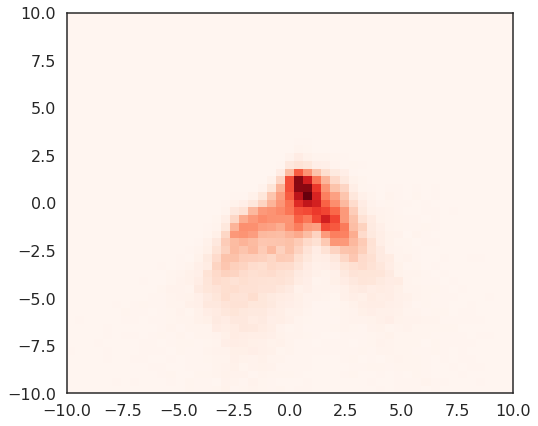

In [137]:
bins = np.linspace(-10,10,50)
plt.hist2d(z_last_fts[:,0].numpy(), y=z_last_fts[:,1].numpy(), bins=(bins, bins), cmap=plt.cm.Reds)
plt.show()

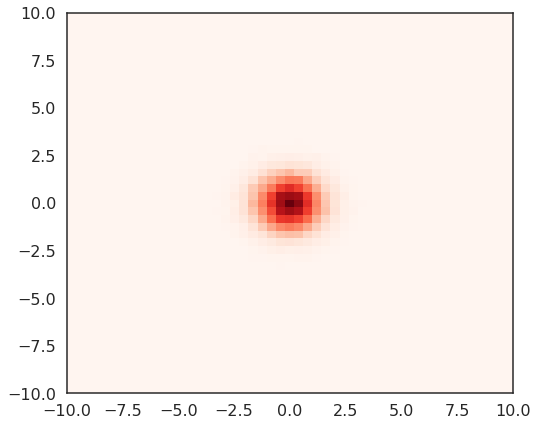

In [138]:
bins = np.linspace(-10,10,50)
plt.hist2d(z_0_fts[:,0].numpy(), y=z_0_fts[:,1].numpy(), bins=(bins, bins), cmap=plt.cm.Reds)
plt.show()